## Imports

In [1]:
import logging
import multiprocessing
import os
import sys
from pathlib import Path

import pandas as pd

sys.path.insert(1, "../workflow/scripts")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

cpu_count = multiprocessing.cpu_count()
print("Available cores:", cpu_count)

Available cores: 12


In the next cell, the user provides the input files and configures options for the analysis.

- `PATH_TO_COUNT_DATA`: Raw, unnormalized count matrix used as input for DESeq2 or edgeR.
  
- `PATH_TO_META_DATA`: Data frame with condition factor and covariates to control for. The index must match the columns of count data. Must have a column called "Condition". Any additional columns are assumed to be covariates to control for.
  
- `TRIALS`: Total number of bootstrap trials. If this number is increased later, new results will be appended to existing results until the desired number of trials is reached.

In the example data provided, we compare two breast cancer subtypes: basal-like and luminal A, with $n=5$ replicates each. The analysis is controlled for tumor purity and age. Data is obtained from TCGA.

In [19]:
PATH_TO_COUNT_DATA = "/home/peter/Work/ExtProjects/CHEK2/kallisto.merged.gene_counts.tsv"
df = pd.read_csv(PATH_TO_COUNT_DATA, index_col=0, sep="\t")
df.drop("gene_name", axis=1).to_csv("/home/peter/Work/ExtProjects/CHEK2/kallisto.merged.gene_counts.csv")
PATH_TO_COUNT_DATA = "/home/peter/Work/ExtProjects/CHEK2/kallisto.merged.gene_counts.csv"

meta = pd.DataFrame([d for d in df.columns if d != "gene_name"])
meta.set_index(0, inplace=True)
meta.index.name = "Sample"
meta["Condition"] = [m[:-1] for m in meta.index]
PATH_TO_META_DATA = "/home/peter/Work/ExtProjects/CHEK2/kallisto.merged.meta.csv"
meta.to_csv(PATH_TO_META_DATA)

NAME = "CHK2"  # name to tag output files with
SAVE_PATH = "../results/CHK2"  # recommended to save in custom folder
TRIALS = 5
METHOD = "edgeR"  # deseq2 or edgeR
LFC = 1  # formal log fold change threshold used for DEG testing
FDR = 0.05  # adjusted p-value to define DEGs

In [2]:
PATH_TO_COUNT_DATA = "../resources/BSLA.N5.csv"
PATH_TO_META_DATA = "../resources/BSLA.N5.meta.csv"
NAME = "BSLA.N5"  # name to tag output files with
SAVE_PATH = "../results/BSLA.N5"  # recommended to save in custom folder
TRIALS = 25
METHOD = "edgeR"  # deseq2 or edgeR
LFC = 1  # formal log fold change threshold used for DEG testing
FDR = 0.05  # adjusted p-value to define DEGs

In [20]:
counts = pd.read_csv(PATH_TO_COUNT_DATA, index_col=0)
display(counts.head())

meta = pd.read_csv(PATH_TO_META_DATA, index_col=0)
meta.head()

,KO1,KO2,KO3,Par1,Par2,Par3
gene_id,,,,,,
ENSG00000000003,845.96866,763.13619,869.21940,1026.326900,767.77900,737.927080
ENSG00000000005,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000
ENSG00000000419,1166.67420,1435.88319,1394.56026,1304.279818,1562.35495,1155.270869
ENSG00000000457,288.84940,259.50690,332.87122,295.662600,230.54986,260.939800
ENSG00000000460,474.10997,638.99950,601.00055,540.709200,718.28465,525.169360


,Condition
Sample,
KO1,KO
KO2,KO
KO3,KO
Par1,Par
Par2,Par


## Run DEA on original cohort

In future versions, users will be able to specify their own R (or Python) script to run bootstrapping. For now, we demonstrate the method assuming the user has DESeq2 or edgeR installed.

In [21]:
from DEA import run_dea


OUTFILE_ORIGINAL = Path(SAVE_PATH) / f"{NAME}.original.{METHOD}.lfc{LFC}.csv"
run_dea(counts, outfile=OUTFILE_ORIGINAL, method=METHOD, design=PATH_TO_META_DATA, lfc=LFC, overwrite=False)

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


INFO:root:
Calling edgeR in R with kwargs:
{}



[1] "Constructing design matrix from df"
[1] "Formula: ~"         "Formula: Condition"
[1] 6
[1] 6


Let's inspect the results from the original cohort before bootstrapping:

DEGs: 104 | Upregulated: 69 | Downregulated: 35


,logFC,unshrunk.logFC,logCPM,PValue,FDR
ENSG00000180530,11.244193,1.170058e+01,4.869792,2.452114e-15,1.550741e-10
ENSG00000075213,4.137885,4.139591e+00,5.596937,6.695583e-12,2.117177e-07
ENSG00000171617,3.552833,3.553758e+00,5.886710,1.697619e-11,3.578637e-07
ENSG00000196954,11.763003,1.442695e+08,3.514435,7.288532e-11,1.010727e-06
ENSG00000162409,5.709953,5.744643e+00,2.865466,7.991073e-11,1.010727e-06


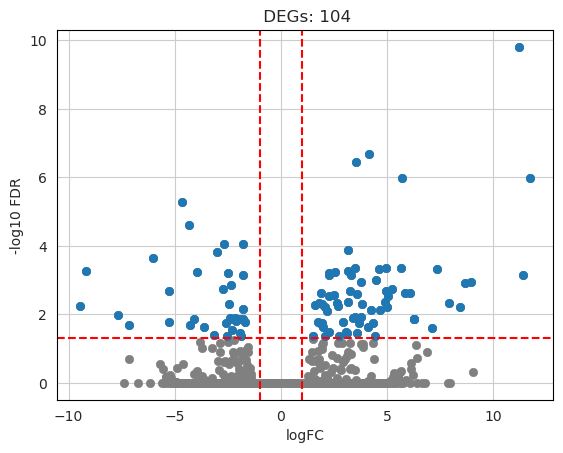

In [24]:
from plotting import make_volcano


tab = pd.read_csv(OUTFILE_ORIGINAL, index_col=0)
sig = tab[tab["FDR"] < FDR]
up = sig[sig["logFC"] > LFC]
down = sig[sig["logFC"] < -LFC]
print(f"DEGs: {len(sig)} | Upregulated: {len(up)} | Downregulated: {len(down)}")
display(tab.head())
make_volcano(tab, lfc=LFC, fdr=FDR)

## Run bootstrapped DEA

In [25]:
from bootstrap import bootstrap_data


bootstrap_data(
    df=counts,
    save_path=SAVE_PATH,
    lfc=LFC,
    design="custom",
    method=METHOD,
    name=NAME,
    trials=TRIALS,
    meta=meta,
    logfile=f"{SAVE_PATH}/log.txt",
    maxiter=5,
)


# Remove intermediate results
os.system(f"rm {SAVE_PATH}/tmp/*")

INFO:root:No bootstrap results file found: ../results/CHK2
INFO:root:Initializing resultsfile
INFO:root:Running trial: 1, samples: Index(['KO2', 'KO1', 'KO1', 'Par2', 'Par2', 'Par1'], dtype='object'), path: ../results/CHK2
INFO:root:
Calling edgeR in R with kwargs:
{}



[1] "Constructing design matrix from df"
[1] "Formula: ~"         "Formula: Condition"
[1] 6
[1] 6


INFO:root:Running trial: 2, samples: Index(['KO1', 'KO2', 'KO1', 'Par3', 'Par3', 'Par1'], dtype='object'), path: ../results/CHK2
INFO:root:
Calling edgeR in R with kwargs:
{}



[1] "Constructing design matrix from df"
[1] "Formula: ~"         "Formula: Condition"
[1] 6
[1] 6


INFO:root:Running trial: 3, samples: Index(['KO3', 'KO1', 'KO2', 'Par1', 'Par1', 'Par1'], dtype='object'), path: ../results/CHK2
INFO:root:
Calling edgeR in R with kwargs:
{}



[1] "Constructing design matrix from df"
[1] "Formula: ~"         "Formula: Condition"
[1] 6
[1] 6


INFO:root:Running trial: 4, samples: Index(['KO3', 'KO3', 'KO2', 'Par2', 'Par1', 'Par1'], dtype='object'), path: ../results/CHK2
INFO:root:
Calling edgeR in R with kwargs:
{}



[1] "Constructing design matrix from df"
[1] "Formula: ~"         "Formula: Condition"
[1] 6
[1] 6


INFO:root:Running trial: 5, samples: Index(['KO3', 'KO2', 'KO3', 'Par3', 'Par1', 'Par2'], dtype='object'), path: ../results/CHK2
INFO:root:
Calling edgeR in R with kwargs:
{}



[1] "Constructing design matrix from df"
[1] "Formula: ~"         "Formula: Condition"
[1] 6
[1] 6


0

## Inspect results

The bootstrapping returns a long dataframe with all trial results concatenated:

In [26]:
results_file = f"{SAVE_PATH}/{NAME}.boot.trials{TRIALS}.{METHOD}.csv"
merged_trials = pd.read_csv(results_file, index_col=0)
merged_trials.tail()

,logFC,unshrunk.logFC,logCPM,PValue,FDR,Trial
ENSG00000293542,0.0,0.0,-3.289593,1.0,1.0,5
ENSG00000293544,0.0,0.0,-3.289593,1.0,1.0,5
ENSG00000293554,0.0,0.0,-3.289593,1.0,1.0,5
ENSG00000293555,0.0,0.0,-3.289593,1.0,1.0,5
ENSG00000293559,0.0,0.0,-3.289593,1.0,1.0,5


We now calculate Spearman rank correlations of the logFC estimates between the bootstrapped and original data sets:

In [28]:
import numpy as np
from bootstrap import compute_spearmans


spearmans = compute_spearmans(tab_reference=tab, merged_trials=merged_trials)
print(f"Median Spearman: {np.median(spearmans):.3f}")
print(f"Standard deviation: {np.std(spearmans):.3f}")

Median Spearman: 0.703
Standard deviation: 0.055


In the original study by Degen and Medo (2025), we found that Spearman correlations above ~0.9 yield generally reliable results. Conversely, if correlations are lower then ~0.8, we recommend interpreting differential expression and enrichment results with caution.

We can also compare the observed Spearman correlation with the results from our original study.

Precision: 0.34 (n=5)
Precision: 0.49 (n=10)
Recall: 0.00 (n=5)
Recall: 0.00 (n=10)
Replicability: 0.00 (n=5)
Replicability: 0.00 (n=10)


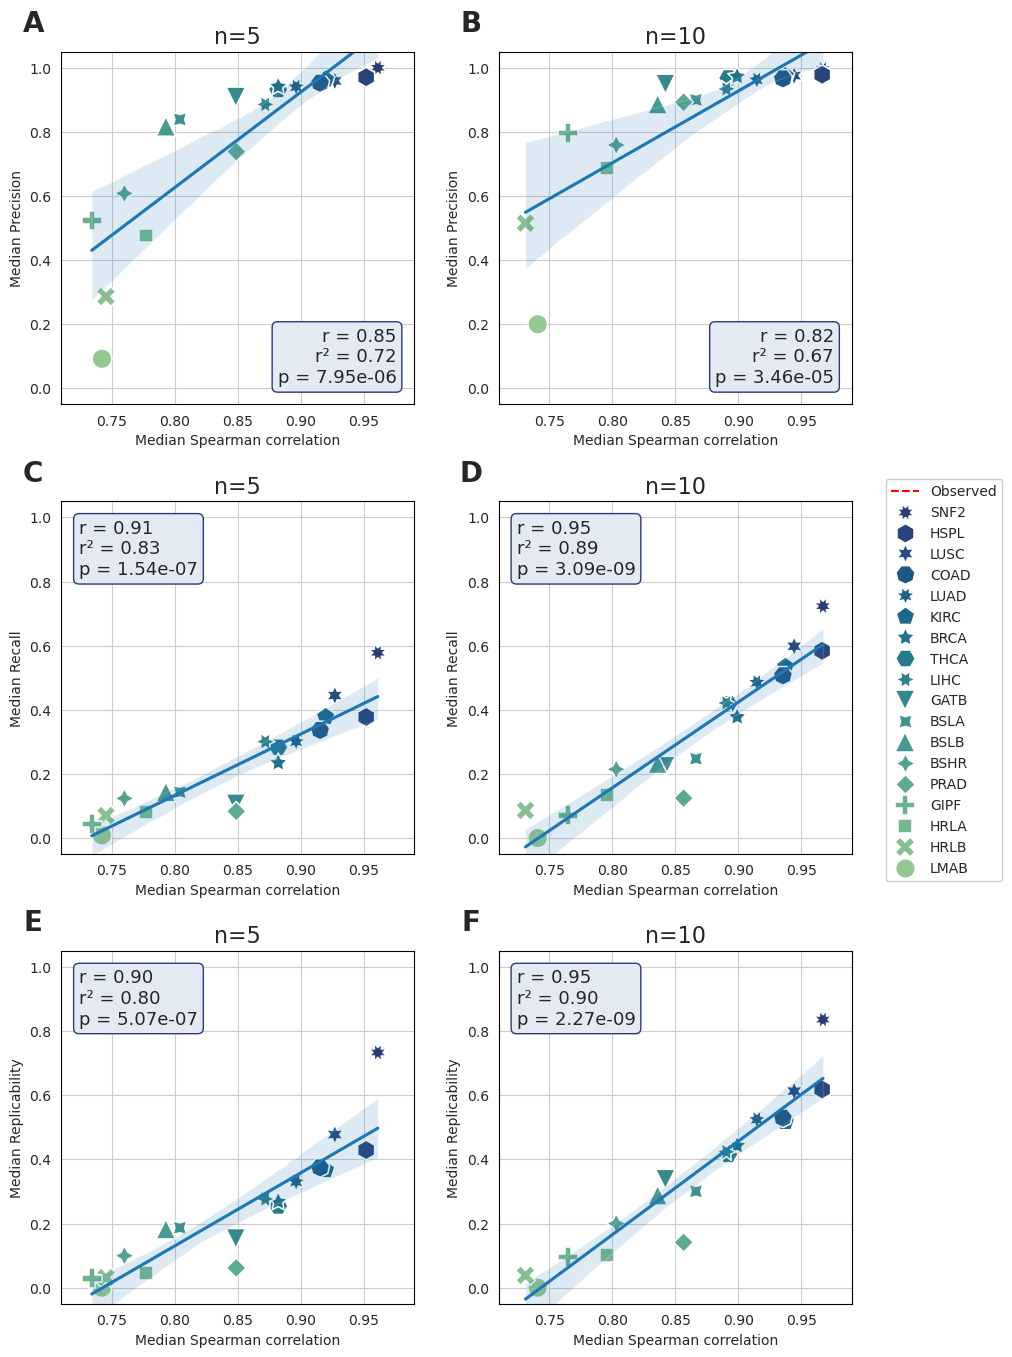

In [29]:
from misc import predict_metrics
from plotting import compare_plot


fig = compare_plot(observed_spearman=np.median(spearmans))
fig.tight_layout()

predictions = predict_metrics(observed_spearman=np.median(spearmans))

for metric in predictions:
    print(f"{metric}: {predictions[metric][5]:.2f} (n=5)")
    print(f"{metric}: {predictions[metric][10]:.2f} (n=10)")

We can also inspect Supplementary Figue 21. from Degen and Medo (2025) to asses the variability of the Spearman correlations for our 18 tested data sets. Box plots show results from 50 cohorts of size $N$ per data set, with $k=25$ trials per cohort. The observed precision of DEGs is printed with the box plots.

![Supplementary Figure 21: Spearman variability (Degen and Medo, 2025)](../assets//sfig.spearman.var.png)

# Ground truth comparison

If a ground truth is available (unlikely in most scenarios), we can compute precision and recall to compare with the bootstrapped prediction. For the BSLA test data, the ground truth is defined from the full cohort with $n=126$.

In [13]:
from misc import print_metrics


truth = pd.read_csv("../resources/BSLA.deseq2.lfc1.csv", index_col=0)
print_metrics(truth, tab, FDR=FDR)

MCC:       0.32
Precision: 0.85
Recall:    0.14
True:      2039
Pred:       340
TP:         288
FP:          52
TN:       16097
FN:        1751


In the example BSLA data with $n=5$, our predicted precision (0.89) is close to our observed value (0.85). However, it seems we got unlucky and our observed recall (0.14) is lower than predicted (0.30).

In [ ]:
# import importlib
# import sys
# importlib.reload(sys.modules["plotting"])